Epoch 1/30


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


8/8 ━━━━━━━━━━━━━━━━━━━━ 102s 5s/step - inundado_accuracy: 0.4754 - inundado_loss: 0.9092 - loss: 2.2942 - transitable_accuracy: 0.4945 - transitable_loss: 1.3838 - val_inundado_accuracy: 0.5714 - val_inundado_loss: 0.6900 - val_loss: 1.3918 - val_transitable_accuracy: 0.4286 - val_transitable_loss: 0.7018 - learning_rate: 1.0000e-06
Epoch 2/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 159ms/step - inundado_accuracy: 0.4631 - inundado_loss: 0.9955 - loss: 2.2769 - transitable_accuracy: 0.4025 - transitable_loss: 1.2858 - val_inundado_accuracy: 0.5714 - val_inundado_loss: 0.6896 - val_loss: 1.3915 - val_transitable_accuracy: 0.4286 - val_transitable_loss: 0.7019 - learning_rate: 1.0000e-06
Epoch 3/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 151ms/step - inundado_accuracy: 0.5039 - inundado_loss: 0.8253 - loss: 2.1639 - transitable_accuracy: 0.4948 - transitable_loss: 1.3386 - val_inundado_accuracy: 0.5714 - val_inundado_loss: 0.6892 - val_loss: 1.3909 - val_transitable_accuracy: 0.4286 - val_transitable_loss: 0.7

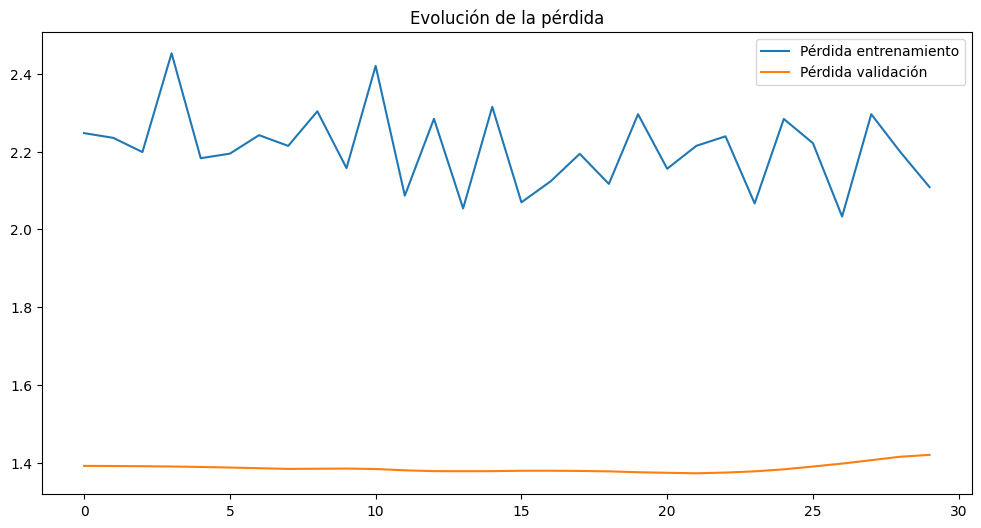

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step - inundado_accuracy: 0.7143 - inundado_loss: 0.6904 - loss: 1.4201 - transitable_accuracy: 0.4286 - transitable_loss: 0.7297

=== Resultados en Prueba ===
loss: 1.4201
compile_metrics: 0.7297
transitable_loss: 0.6904
inundado_loss: 0.7143


In [22]:
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Input, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import cv2
import os
import matplotlib.pyplot as plt
from datetime import datetime

## Configuración de GPU
physical_devices = tf.config.list_physical_devices('GPU')
if len(physical_devices) > 0:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)

## Parámetros
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 30
INIT_LR = 1e-6

## Rutas
TRAIN_CSV = '/kaggle/input/dataset/labels/train_data.csv'
TRAIN_IMG_DIR = '/kaggle/input/dataset/images'
TEST_CSV = '/kaggle/input/test-all/labels/test_data.csv'
TEST_IMG_DIR = '/kaggle/input/test-all/images'

## Carga de datos
train_df = pd.read_csv(TRAIN_CSV)
test_df = pd.read_csv(TEST_CSV)

## Balanceo de datos
class_counts = train_df[['transitable', 'Inundado']].sum()
max_count = class_counts.max()
train_df_balanced = train_df.copy()
for col in ['transitable', 'Inundado']:
    samples_to_add = max_count - class_counts[col]
    if samples_to_add > 0:
        additional_samples = train_df[train_df[col] == 1].sample(samples_to_add, replace=True)
        train_df_balanced = pd.concat([train_df_balanced, additional_samples])

## Generador de datos
class MultiTargetGenerator(tf.keras.utils.Sequence):
    def __init__(self, df, img_dir, batch_size=32, shuffle=True, augment=False):
        self.df = df.reset_index(drop=True)
        self.img_dir = img_dir
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.augment = augment
        self.on_epoch_end()
        
        self.augmenter = ImageDataGenerator(
            rotation_range=30,
            width_shift_range=0.3,
            height_shift_range=0.3,
            shear_range=0.3,
            zoom_range=0.3,
            horizontal_flip=True,
            fill_mode='nearest'
        )
    
    def __len__(self):
        return int(np.ceil(len(self.df) / self.batch_size))
    
    def __getitem__(self, index):
        start_idx = index * self.batch_size
        end_idx = min((index + 1) * self.batch_size, len(self.df))
        batch_indices = self.indices[start_idx:end_idx]
        
        X = np.empty((len(batch_indices), *IMG_SIZE, 3))
        y_transitable = np.empty((len(batch_indices), 1))
        y_inundado = np.empty((len(batch_indices), 1))
        
        for i, idx in enumerate(batch_indices):
            row = self.df.iloc[idx]
            img_path = os.path.join(self.img_dir, f"{row['ID']}.jpg")
            
            img = cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, IMG_SIZE)
            
            if self.augment:
                img = self.augmenter.random_transform(img)
                
            X[i,] = img / 255.0
            
            y_transitable[i,] = row['transitable']
            y_inundado[i,] = row['Inundado']
            
        return X, {'transitable': y_transitable, 'inundado': y_inundado}
    
    def on_epoch_end(self):
        self.indices = np.arange(len(self.df))
        if self.shuffle:
            np.random.shuffle(self.indices)

## Modelo

def build_multi_target_model():
    base_model = EfficientNetB0(
        include_top=False,
        weights='imagenet',
        input_shape=(*IMG_SIZE, 3),
        pooling='avg'
    )
    base_model.trainable = True  # Permitir ajuste fino
    
    inputs = Input(shape=(*IMG_SIZE, 3))
    x = base_model(inputs)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    
    transitable_branch = Dense(128, activation='relu')(x)
    transitable_branch = Dropout(0.3)(transitable_branch)
    transitable_output = Dense(1, activation='sigmoid', name='transitable')(transitable_branch)
    
    inundado_branch = Dense(128, activation='relu')(x)
    inundado_branch = Dropout(0.3)(inundado_branch)
    inundado_output = Dense(1, activation='sigmoid', name='inundado')(inundado_branch)
    
    model = Model(inputs=inputs, outputs=[transitable_output, inundado_output])

    model.compile(
        optimizer=Adam(learning_rate=INIT_LR),
        loss={'transitable': 'binary_crossentropy', 'inundado': 'binary_crossentropy'},
        metrics={'transitable': ['accuracy'], 'inundado': ['accuracy']}
    )
    
    return model

## Callbacks
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6)

## Evaluación del modelo
def evaluate_on_test(model):
    test_gen = MultiTargetGenerator(test_df, TEST_IMG_DIR, augment=False, shuffle=False, batch_size=BATCH_SIZE)
    results = model.evaluate(test_gen, verbose=1)
    
    print("\n=== Resultados en Prueba ===")
    for i, metric in enumerate(model.metrics_names):
        print(f"{metric}: {results[i]:.4f}")

## Visualización de resultados
def plot_results(history):
    plt.figure(figsize=(12, 6))
    plt.plot(history.history['loss'], label='Pérdida entrenamiento')
    plt.plot(history.history['val_loss'], label='Pérdida validación')
    plt.legend()
    plt.title('Evolución de la pérdida')
    plt.show()

if __name__ == "__main__":
    model = build_multi_target_model()
    history = model.fit(
        MultiTargetGenerator(train_df_balanced, TRAIN_IMG_DIR, augment=True),
        validation_data=MultiTargetGenerator(test_df, TEST_IMG_DIR),
        epochs=EPOCHS,
        callbacks=[reduce_lr]
    )
    plot_results(history)
    evaluate_on_test(model)

In [24]:
# Guardar el modelo con timestamp
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
model_filename = f"modelo_{timestamp}.keras"
model.save(model_filename)
print(f"Modelo guardado como: {model_filename}")

# Guardar el accuracy y el nombre del modelo en un archivo de texto
accuracy_transitable = history.history['val_transitable_accuracy'][-1]
accuracy_inundado = history.history['val_inundado_accuracy'][-1]

results_filename = f"resultados_{timestamp}.txt"
with open(results_filename, "w") as f:
    f.write(f"Modelo: {model_filename}\n")
    f.write(f"Accuracy transitable: {accuracy_transitable:.4f}\n")
    f.write(f"Accuracy inundado: {accuracy_inundado:.4f}\n")

print(f"Resultados guardados en: {results_filename}")


Modelo guardado como: modelo_20250329_184118.keras
Resultados guardados en: resultados_20250329_184118.txt


****Juanmi Changes****


=== Configuración Inicial ===
GPU configurada con memory_growth

Cargando datos...

Dividiendo datos...
Muestras entrenamiento: 201
Muestras validación: 51
Muestras prueba: 7

Resumen del modelo:


Model: "functional_16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_33            │ (32, 224, 224, 3)      │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ efficientnetb0            │ (32, 7, 7, 1280)       │      4,049,571 │ input_layer_33[0][0]   │
│ (Functional)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling2d… │ (32, 1280)             │              0 │ efficientnetb0[0][0]   │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_40    │ (32, 1280)             │          5,120 │ global_average_poolin… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_56 (Dropout)      │ (32, 1280)             │              0 │ batch_normalization_4… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_40 (Dense)          │ (32, 512)              │        655,872 │ dropout_56[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_41    │ (32, 512)              │          2,048 │ dense_40[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_57 (Dropout)      │ (32, 512)              │              0 │ batch_normalization_4… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_41 (Dense)          │ (32, 256)              │        131,328 │ dropout_57[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_42 (Dense)          │ (32, 256)              │        131,328 │ dropout_57[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_42    │ (32, 256)              │          1,024 │ dense_41[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_43    │ (32, 256)              │          1,024 │ dense_42[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_58 (Dropout)      │ (32, 256)              │              0 │ batch_normalization_4… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_59 (Dropout)      │ (32, 256)              │              0 │ batch_normalization_4… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ transitable (Dense)       │ (32, 1)                │            257 │ dropout_58[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ inundado (Dense)          │ (32, 1)                │            257 │ dropout_59[0][0]       │
└──────────────────────

 Total params: 4,977,829 (18.99 MB)

 Trainable params: 4,763,998 (18.17 MB)

 Non-trainable params: 213,831 (835.28 KB)


Iniciando entrenamiento...
Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - inundado_accuracy: 0.4933 - inundado_auc: 0.5133 - inundado_loss: 1.0096 - inundado_precision: 0.4196 - inundado_recall: 0.4967 - loss: 2.0444 - transitable_accuracy: 0.4915 - transitable_auc: 0.5047 - transitable_loss: 1.0493 - transitable_precision: 0.4427 - transitable_recall: 0.4548
Epoch 1: val_loss improved from inf to 1.37331, saving model to best_model_effnet_20250329_181953.keras
7/7 ━━━━━━━━━━━━━━━━━━━━ 82s 5s/step - inundado_accuracy: 0.4888 - inundado_auc: 0.5075 - inundado_loss: 1.0006 - inundado_precision: 0.4134 - inundado_recall: 0.4903 - loss: 2.0346 - transitable_accuracy: 0.4935 - transitable_auc: 0.5045 - transitable_loss: 1.0498 - transitable_precision: 0.4388 - transitable_recall: 0.4537 - val_inundado_accuracy: 0.5882 - val_inundado_auc: 0.5000 - val_inundado_loss: 0.6900 - val_inundado_precision: 0.0000e+00 - val_inundado_recall: 0.0000e+00 - val_loss: 1.3733 - val_transitable_accuracy: 0.5882 - val_transitable_auc: 0.5000 -

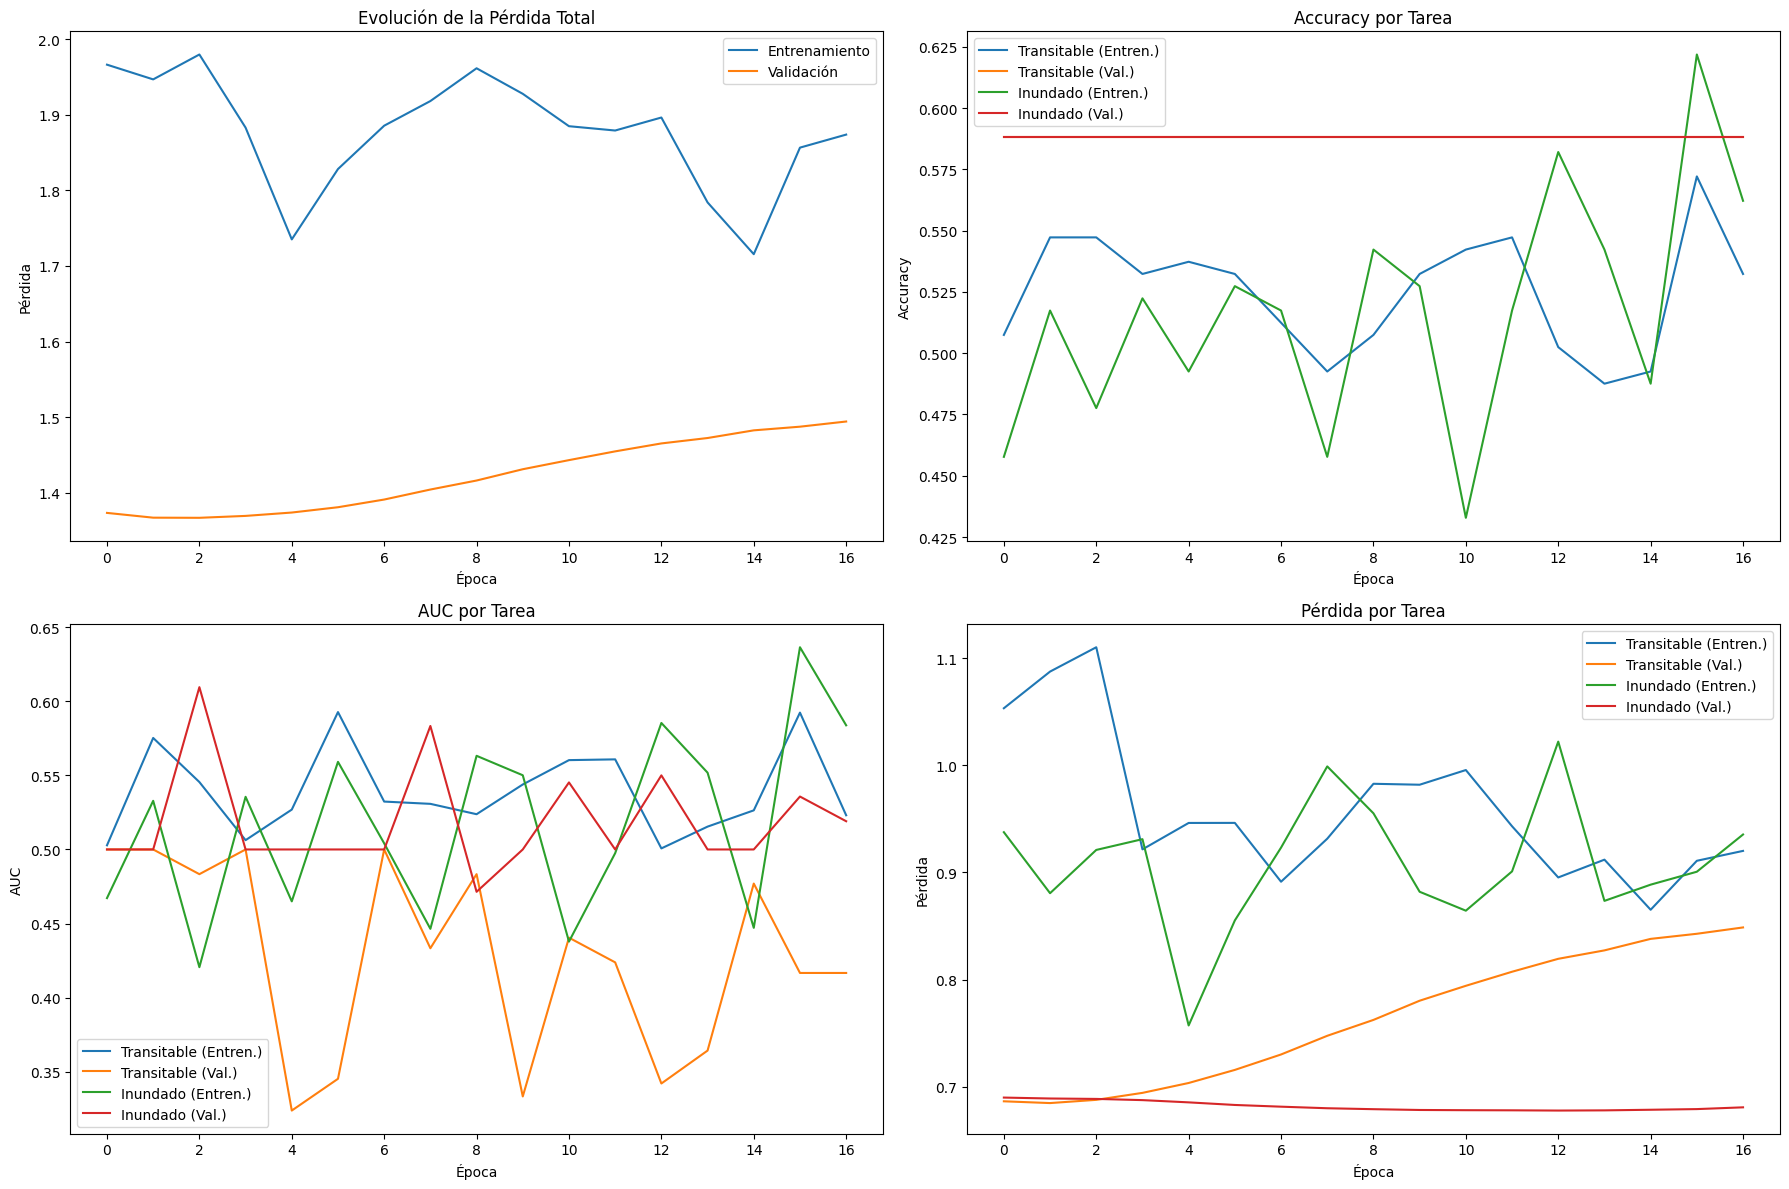


=== Evaluación Detallada ===
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - inundado_accuracy: 0.5714 - inundado_auc: 0.5000 - inundado_loss: 0.6899 - inundado_precision: 0.0000e+00 - inundado_recall: 0.0000e+00 - loss: 1.3728 - transitable_accuracy: 0.5714 - transitable_auc: 0.5000 - transitable_loss: 0.6829 - transitable_precision: 0.0000e+00 - transitable_recall: 0.0000e+00

Resultados en conjunto de prueba:
Pérdida total: 1.3728
Pérdida transitable: 0.6829
Pérdida inundado: 0.6899
Accuracy transitable: 0.5714
Precisión transitable: 0.5000
Recall transitable: 0.0000
AUC transitable: 0.0000
Accuracy inundado: 0.5714
Precisión inundado: 0.5000
Recall inundado: 0.0000
AUC inundado: 0.0000

Modelo final guardado como 'final_model_effnet_20250329_182228.keras'


In [21]:
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Input, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import (ReduceLROnPlateau, EarlyStopping, 
                                      ModelCheckpoint, CSVLogger, TensorBoard)
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
import numpy as np
import pandas as pd
import cv2
import os
import matplotlib.pyplot as plt
from datetime import datetime

# 1. Configuración de GPU
print("\n=== Configuración Inicial ===")
physical_devices = tf.config.list_physical_devices('GPU')
if len(physical_devices) > 0:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
    print("GPU configurada con memory_growth")
else:
    print("No se detectó GPU, usando CPU")

# 2. Parámetros del modelo
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 50
INIT_LR = 1e-5

# 3. Rutas de los datos
TRAIN_CSV = '/kaggle/input/dataset/labels/train_data.csv'
TRAIN_IMG_DIR = '/kaggle/input/dataset/images'
TEST_CSV = '/kaggle/input/test-all/labels/test_data.csv'
TEST_IMG_DIR = '/kaggle/input/test-all/images'

# 4. Carga y verificación de datos
print("\nCargando datos...")
train_df = pd.read_csv(TRAIN_CSV)
test_df = pd.read_csv(TEST_CSV)

# Verificar que las imágenes existen
sample_train_img = os.path.join(TRAIN_IMG_DIR, f"{train_df.iloc[0]['ID']}.jpg")
sample_test_img = os.path.join(TEST_IMG_DIR, f"{test_df.iloc[0]['ID']}.jpg")

if not os.path.exists(sample_train_img):
    raise FileNotFoundError(f"Imagen de entrenamiento no encontrada: {sample_train_img}")
if not os.path.exists(sample_test_img):
    raise FileNotFoundError(f"Imagen de prueba no encontrada: {sample_test_img}")

# 5. División estratificada de datos
print("\nDividiendo datos...")
train_df, val_df = train_test_split(
    train_df, 
    test_size=0.2, 
    random_state=42, 
    stratify=train_df[['transitable', 'Inundado']]
)
print(f"Muestras entrenamiento: {len(train_df)}")
print(f"Muestras validación: {len(val_df)}")
print(f"Muestras prueba: {len(test_df)}")

# 6. Generador de datos mejorado con balanceo de clases y pesos de muestra
class MultiTargetGenerator(tf.keras.utils.Sequence):
    def __init__(self, df, img_dir, batch_size=32, shuffle=True, augment=False):
        self.df = df.reset_index(drop=True)
        self.img_dir = img_dir
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.augment = augment
        self.on_epoch_end()
        
        # Configuración de aumento de datos
        self.augmenter = ImageDataGenerator(
            rotation_range=30,
            width_shift_range=0.2,
            height_shift_range=0.2,
            shear_range=0.2,
            zoom_range=0.2,
            horizontal_flip=True,
            vertical_flip=True,
            brightness_range=[0.8, 1.2],
            fill_mode='constant',
            cval=0
        )
    
    def __len__(self):
        return int(np.ceil(len(self.df) / self.batch_size))
    
    def __getitem__(self, index):
        start_idx = index * self.batch_size
        end_idx = min((index + 1) * self.batch_size, len(self.df))
        batch_indices = self.indices[start_idx:end_idx]
        current_batch_size = len(batch_indices)
        
        # Pre-asignar memoria para mejor rendimiento con GPU
        X = np.empty((current_batch_size, *IMG_SIZE, 3), dtype=np.float32)
        y_transitable = np.empty((current_batch_size, 1), dtype=np.float32)
        y_inundado = np.empty((current_batch_size, 1), dtype=np.float32)
        
        for i, idx in enumerate(batch_indices):
            row = self.df.iloc[idx]
            img_path = os.path.join(self.img_dir, f"{row['ID']}.jpg")
            
            img = cv2.imread(img_path)
            if img is None:
                raise ValueError(f"No se pudo cargar la imagen: {img_path}")
                
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, IMG_SIZE)
            
            if self.augment:
                img = self.augmenter.random_transform(img)
                
            X[i,] = img / 255.0  # Normalización
            
            y_transitable[i,] = row['transitable']
            y_inundado[i,] = row['Inundado']
            
        # Convertir a tensores para mejor compatibilidad con GPU
        X = tf.convert_to_tensor(X, dtype=tf.float32)
        y_transitable = tf.convert_to_tensor(y_transitable, dtype=tf.float32)
        y_inundado = tf.convert_to_tensor(y_inundado, dtype=tf.float32)
            
        return X, {'transitable': y_transitable, 'inundado': y_inundado}

    def on_epoch_end(self):
        self.indices = np.arange(len(self.df))
        if self.shuffle:
            np.random.shuffle(self.indices)


def build_enhanced_model():
    base_model = EfficientNetB0(
        include_top=False,
        weights='imagenet',
        input_shape=(*IMG_SIZE, 3),
        pooling=None
    )

    # Congelar las primeras capas para fine-tuning más eficiente
    base_model.trainable = True
    for layer in base_model.layers[:100]:
        layer.trainable = False
    
    inputs = Input(shape=(*IMG_SIZE, 3), batch_size=BATCH_SIZE)
    x = base_model(inputs)
    
    # Capas adicionales para extraer características
    x = GlobalAveragePooling2D()(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    x = Dense(512, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)
    
    # Ramas específicas para cada tarea
    transitable_branch = Dense(256, activation='relu')(x)
    transitable_branch = BatchNormalization()(transitable_branch)
    transitable_branch = Dropout(0.3)(transitable_branch)
    transitable_output = Dense(1, activation='sigmoid', name='transitable')(transitable_branch)
    
    inundado_branch = Dense(256, activation='relu')(x)
    inundado_branch = BatchNormalization()(inundado_branch)
    inundado_branch = Dropout(0.3)(inundado_branch)
    inundado_output = Dense(1, activation='sigmoid', name='inundado')(inundado_branch)
    
    model = Model(inputs=inputs, outputs=[transitable_output, inundado_output])
    
    return model

# 8. Compilación del modelo con métricas adicionales
def compile_enhanced_model(model):
    model.compile(
        optimizer=Adam(learning_rate=INIT_LR),
        loss={
            'transitable': 'binary_crossentropy',
            'inundado': 'binary_crossentropy'
        },
        loss_weights={
            'transitable': 1.0,
            'inundado': 1.0
        },
        metrics={
            'transitable': ['accuracy', tf.keras.metrics.Precision(name='precision'), 
                           tf.keras.metrics.Recall(name='recall'), 
                           tf.keras.metrics.AUC(name='auc')],
            'inundado': ['accuracy', tf.keras.metrics.Precision(name='precision'), 
                       tf.keras.metrics.Recall(name='recall'),
                       tf.keras.metrics.AUC(name='auc')]
        }
    )
    return model

# 9. Callbacks mejorados
def get_enhanced_callbacks():
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    return [
        EarlyStopping(
            monitor='val_loss',
            patience=15,
            restore_best_weights=True,
            min_delta=0.001,
            verbose=1
        ),
        ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=5,
            min_lr=1e-5,
            verbose=1
        ),
        ModelCheckpoint(
            f'best_model_effnet_{timestamp}.keras',
            save_best_only=True,
            monitor='val_loss',
            mode='min',
            verbose=1
        ),
        CSVLogger(f'training_log_effnet_{timestamp}.csv'),
        TensorBoard(log_dir=f'./logs/effnet_{timestamp}')
    ]

# 10. Evaluación mejorada del modelo
def enhanced_evaluation(model, test_gen):
    print("\n=== Evaluación Detallada ===")
    results = model.evaluate(test_gen, verbose=1)
    
    print("\nResultados en conjunto de prueba:")
    print(f"Pérdida total: {results[0]:.4f}")
    print(f"Pérdida transitable: {results[1]:.4f}")
    print(f"Pérdida inundado: {results[2]:.4f}")
    print(f"Accuracy transitable: {results[3]:.4f}")
    print(f"Precisión transitable: {results[4]:.4f}")
    print(f"Recall transitable: {results[5]:.4f}")
    print(f"AUC transitable: {results[6]:.4f}")
    print(f"Accuracy inundado: {results[7]:.4f}")
    print(f"Precisión inundado: {results[8]:.4f}")
    print(f"Recall inundado: {results[9]:.4f}")
    print(f"AUC inundado: {results[10]:.4f}")

# 11. Visualización mejorada de resultados
def plot_enhanced_results(history):
    plt.figure(figsize=(18, 12))
    
    # Pérdida total
    plt.subplot(2, 2, 1)
    plt.plot(history.history['loss'], label='Entrenamiento')
    plt.plot(history.history['val_loss'], label='Validación')
    plt.title('Evolución de la Pérdida Total')
    plt.ylabel('Pérdida')
    plt.xlabel('Época')
    plt.legend()
    
    # Accuracy por tarea
    plt.subplot(2, 2, 2)
    plt.plot(history.history['transitable_accuracy'], label='Transitable (Entren.)')
    plt.plot(history.history['val_transitable_accuracy'], label='Transitable (Val.)')
    plt.plot(history.history['inundado_accuracy'], label='Inundado (Entren.)')
    plt.plot(history.history['val_inundado_accuracy'], label='Inundado (Val.)')
    plt.title('Accuracy por Tarea')
    plt.ylabel('Accuracy')
    plt.xlabel('Época')
    plt.legend()
    
    # AUC por tarea
    plt.subplot(2, 2, 3)
    plt.plot(history.history['transitable_auc'], label='Transitable (Entren.)')
    plt.plot(history.history['val_transitable_auc'], label='Transitable (Val.)')
    plt.plot(history.history['inundado_auc'], label='Inundado (Entren.)')
    plt.plot(history.history['val_inundado_auc'], label='Inundado (Val.)')
    plt.title('AUC por Tarea')
    plt.ylabel('AUC')
    plt.xlabel('Época')
    plt.legend()
    
    # Pérdida por tarea
    plt.subplot(2, 2, 4)
    plt.plot(history.history['transitable_loss'], label='Transitable (Entren.)')
    plt.plot(history.history['val_transitable_loss'], label='Transitable (Val.)')
    plt.plot(history.history['inundado_loss'], label='Inundado (Entren.)')
    plt.plot(history.history['val_inundado_loss'], label='Inundado (Val.)')
    plt.title('Pérdida por Tarea')
    plt.ylabel('Pérdida')
    plt.xlabel('Época')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

# 12. Ejecución principal
if __name__ == "__main__":
    try:
        # Crear generadores
        train_gen = MultiTargetGenerator(
            train_df, 
            TRAIN_IMG_DIR, 
            batch_size=BATCH_SIZE,
            augment=True,
            shuffle=True
        )
        
        val_gen = MultiTargetGenerator(
            val_df, 
            TRAIN_IMG_DIR, 
            batch_size=BATCH_SIZE,
            augment=False,
            shuffle=False
        )
        
        test_gen = MultiTargetGenerator(
            test_df, 
            TEST_IMG_DIR, 
            batch_size=BATCH_SIZE,
            augment=False,
            shuffle=False
        )
        
        # Construir y compilar modelo
        model = build_enhanced_model()
        model = compile_enhanced_model(model)
        print("\nResumen del modelo:")
        model.summary()
        
        # Entrenamiento
        print("\nIniciando entrenamiento...")
        history = model.fit(
            train_gen,
            validation_data=val_gen,
            epochs=EPOCHS,
            callbacks=get_enhanced_callbacks(),
            verbose=1
        )
        
        # Evaluación y visualización
        plot_enhanced_results(history)
        enhanced_evaluation(model, test_gen)
        
        # Guardar modelo final
        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        model.save(f'final_model_effnet_{timestamp}.keras')
        print(f"\nModelo final guardado como 'final_model_effnet_{timestamp}.keras'")
        
    except Exception as e:
        print(f"\nError durante la ejecución: {e}")
        raise